# Heat Flux from Propellant (Open Burn, Top Down)
## Question: What's a safe distance from a burning propellant mass in terms of heat flux?
***
## Approach: Estimate the safe distance from test data
This notebook treats the heat flux and its estimation based on open burning of propellant in drums or in fires. NOT TREATED HERE are the results from a bottom ignition or an explosion where the burn varies significantly from a some-what steady-state top-down or perimeter-to-center burn of a collection of propellant. Or in other words, explosions are not treated hear or where the propellant is ejected up into the air and subsequently rapidly burns. Clint Guymon, Safety Management Services, Inc.
***
## Conclusions: The safe distance can be correlated to the burn rate
The safe distance is correlated to the burn rate of the propellant based on the body of data compiled (>300 measurements of heat flux with >7 propellant types as well as multiple modeling simulations) for top-down burn scenarios. The proposed relationship is:
\begin{align}
D(m) & = 9.92\cdot B(kg/s)^{1/3}
\end{align}
where D is the safe distance in meters and B is the burn rate in kg per second

***
## Necessary code and data import

In [1]:
#Import necessary packages
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sea
from scipy.optimize import fsolve, minimize

### Import data

The majority of the heat flux data is from "Scaling Studies of Thermal Radiation Flux from Burning Propellants" by J. Hay and R.W. Watson of Bureau of Mines as commissioned by the DDESB in 1992. Various propellant types and masses were tested in a top down burn or external fire of a single barrel or package of propellant.

In [2]:
df = pd.read_csv('jupyterfiles\heatfluxdata.csv')

In [3]:
#define a safe heat flux as a function of distance per second degree burns and a max exposure time of 20 seconds
#(per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns)
qsafeat20 = 0.116 #qsafe at 20 second exposure
def safeHF(t):
    return (t/0.858)**(-1/1.46) if t<20 else qsafeat20

In [4]:
#add new column for unique id = ref id + test id
df['Unique ID'] = df.agg('R{0[Reference ID]}T{0[Test #]}'.format, axis=1)
#add column for burn rate
burnRate = df.groupby('Unique ID').apply(lambda x: np.percentile(x['Mass, kg']/x['Burn time, sec'],75))
burnRate.name = 'Burn rate, kg/s'
#add column for safe heat flux 
safeQ = df.groupby('Unique ID').apply(lambda x: np.percentile(
    [safeHF(x) for x in x['Burn time, sec']],75))
safeQ.name = 'Safe Heat Flux, cal/cm2/sec'
#add to dataframe
df['Burn rate, kg/s'] = df['Unique ID'].apply(lambda x:burnRate.loc[x])
df['Safe Heat Flux, cal/cm2/sec'] = df['Unique ID'].apply(lambda x:safeQ.loc[x])

## Data summary

In [5]:
summary = df.groupby('Reference ID')['Reference'].unique().to_frame()
summary['Propellant types'] = df.groupby('Reference ID')['Propellant type'].unique()
summary['# of Tests'] = df.groupby('Reference ID')['Test #'].nunique()
summary

,Reference,Propellant types,# of Tests
Reference ID,,,
1,"[DDESB BOM ""SCALING STUDIES OF THERMAL RADIATI...","[IMR5010, M1-8-SP, M1-8-MP, WC844, WC846, WCBl...",49
2,"[TNO T 1022 ""Thermal Radiation of Fireworks"" 1...",[Fireworks],16
3,[DDESB IIT Research Institute R. Pape T. Water...,"[M1, WC844]",46
4,"[SMS C. Guymon ""Heat flux from the Top Ignitio...",[WC814],1
5,[China Lake Ranges Test Operation Branch (DB11...,[M1],1


In [6]:
#References
for i,each in enumerate(set(df['Reference'])):
    print(i,":",each) 

0 : China Lake Ranges Test Operation Branch (DB1110M), "Convective Combustion of a Hazard Division 1.3 M1 Gun Propellant in Fiber Barrels Heat Flux Data, 20 March 2020
1 : SMS C. Guymon "Heat flux from the Top Ignition of a Single Barrel of WC814" TEAD 2020
2 : DDESB BOM "SCALING STUDIES OF THERMAL RADIATION FLUX FROM BURNING PROPELLANTS" Hay and Watson 1992
3 : DDESB IIT Research Institute R. Pape T. Waterman A. Takata "Fire Hazards from Combustible Ammunition, Methodology Development (Phase I)" 1980
4 : TNO T 1022 "Thermal Radiation of Fireworks" 1984


In [7]:
#propellant types
set(df['Propellant type'])

{'Fireworks',
 'IMR5010',
 'M1',
 'M1-8-MP',
 'M1-8-SP',
 'WC814',
 'WC844',
 'WC846',
 'WCBlank'}

In [8]:
#number of tests for each propellant
df.groupby('Propellant type')['Test #'].nunique()

Propellant type
Fireworks    16
IMR5010      13
M1           24
M1-8-MP      12
M1-8-SP      14
WC814         1
WC844        27
WC846         3
WCBlank       3
Name: Test #, dtype: int64

In [9]:
#total number of heat flux measurements
len(df)

309

In [10]:
df.describe() #summary statistics for numerical data

,Reference ID,"Mass, kg","Distance, m","Peak heat flux, cal/cm2/sec","Average heat flux, cal/cm2/sec","Burn time, sec","total heat radiated, Mcal","Drum diameter, cm","Burn rate, kg/s","Safe Heat Flux, cal/cm2/sec"
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,154.000000,309.000000,309.000000
mean,1.653722,71.438715,8.711909,0.515390,0.202992,32.340812,38.927398,59.376623,3.134573,0.136680
std,0.986842,69.395979,5.380795,0.691045,0.261836,31.918328,43.713577,3.829841,2.604405,0.034128
min,1.000000,0.340000,1.070000,0.001505,0.000579,3.500000,0.005000,36.000000,0.028333,0.116000
25%,1.000000,45.400000,4.000000,0.066250,0.031000,15.000000,13.700000,60.000000,1.408000,0.116000
50%,1.000000,49.900000,8.000000,0.267000,0.094000,21.900000,21.946223,60.000000,2.907051,0.116000
75%,3.000000,93.000000,15.000000,0.643000,0.261000,35.355339,54.840735,60.000000,3.966667,0.140897
max,5.000000,399.200000,20.000000,5.800000,1.402857,215.000000,229.200000,60.000000,20.000000,0.381763


In [11]:
df.head(3) #first 3 rows of the data frame

,Reference ID,Reference,Propellant type,Test #,"Mass, kg","Distance, m","Peak heat flux, cal/cm2/sec","Average heat flux, cal/cm2/sec","Burn time, sec","total heat radiated, Mcal",Notes,"Drum diameter, cm",Unique ID,"Burn rate, kg/s","Safe Heat Flux, cal/cm2/sec"
0,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,3.2,1.750,0.482,35.0,13.8,Barrel,60.0,R1T1,1.297143,0.116
1,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,4.0,1.050,0.329,35.0,13.8,Barrel,60.0,R1T1,1.297143,0.116
2,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,5.0,1.068,0.289,35.0,13.8,Barrel,60.0,R1T1,1.297143,0.116


## Plot of the Safe Heat Flux vs. Exposure Time

Safe heat flux is per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns. with the included limit that after a duration of 20 seconds, the allowable heat flux remains constant at with increasing exposure time. 

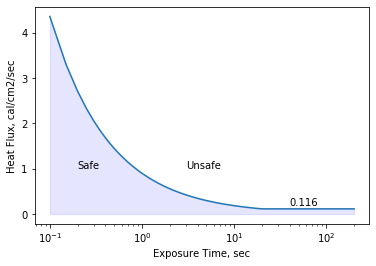

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
x = np.arange(0.1,200,0.05); y=[safeHF(x) for x in x]; #y1=0.3; y0=x*0
ax.set_xscale('log');
sea.lineplot(x,y); #sea.lineplot(x,y1)
ax.fill_between(x,y,color="blue", alpha=0.1)
plt.text(0.2, 1, 'Safe');plt.text(3, 1, 'Unsafe');plt.text(40, 0.2, '0.116') #, bbox=dict(facecolor='red', alpha=0.5))
plt.xlabel('Exposure Time, sec');plt.ylabel('Heat Flux, cal/cm2/sec')
plt.show(block=False)

Here, burn time is equated to the exposure time. After 20 seconds the allowed heat flux is constant at 0.116 cal/cm2/s

### Calculate a "Safe distance"

Calculate a safe distance based on the average heat flux observed in all of the tests to determine the parameters of a modified Point Source Model. Below is the original and modified point source models
\begin{align}
q & = \frac{\alpha}{r^2} \\
q & = \alpha \cdot \bigg(\frac{(1-s)}{r\cdot h} + \frac{s}{r^2}\bigg) \\
\end{align}
where s is a switching function that is between 0 and 1 and transitions at a point out away from the burn where the curve changes from 1/r to 1/r2; h is a parameter relating to the height of a typical cylindrical flame. It has been shown that near a cylindrical flame, the heat flux drops off more like 1/r. 
including the time of exposure (equal to the burn time in seconds) where the safe heat flux (cal/cm2/s) per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns:
\begin{align}
q_\text{safe} & = \bigg(\frac{t}{0.858}\bigg)^\frac{-1}{1.46}
\end{align}

The average heat flux is used instead of the peak heat flux as the peak heat flux is a short term event and is a small fraction of the total burn typically.

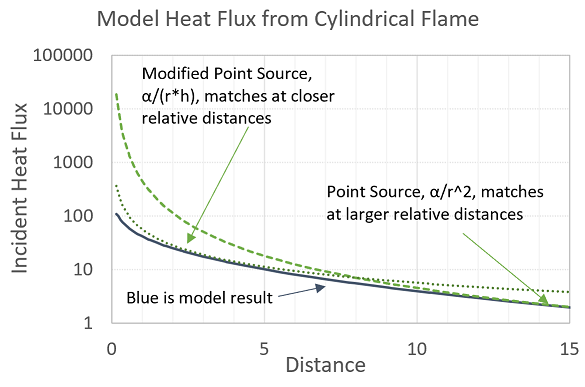

In [13]:
height = 8 

In [14]:
def switch(d, h): #function to transition from 0 to 1 with respect to diameter given a height
    return 1/(1 + (d/h)**-10) #transition point is h and the rate is -10

def modHFOverAlpha(d,h):#heat flux/alpha as a function of distance,d and height,h of the combustion cylinder
    return [(1-switch(d,h))/(d*h)+switch(d,h)/(d**2) for d in d] #this replaces q/apha = 1/d^2

In [15]:
#completed for each test (unique id)
alphas = df.groupby('Unique ID').apply(lambda x: np.percentile(
    x['Average heat flux, cal/cm2/sec']/modHFOverAlpha(x['Distance, m'],height),75))
alphas = [1 if each < 1 else each for each in alphas]
def solve(d):
    return safeQ/alphas - modHFOverAlpha(d,height)

In [16]:
guessDistances = np.sqrt(alphas/safeQ)
safeDistance = fsolve(solve,guessDistances)

In [17]:
safeDistance = pd.Series(safeDistance)
safeDistance.name = 'Safe Distance, m'

In [18]:
safeDistance.index = safeQ.index

In [19]:
df['Safe Distance, m'] =  df['Unique ID'].apply(lambda x:safeDistance.loc[x])

In [20]:
#safeDistance75th = df.groupby('Unique ID').apply(lambda x: np.percentile(x['Safe distance, m'], 75))
#df['Safe Distance, 75th, m'] = df['Unique ID'].apply(lambda x:safeDistance75th.loc[x])

## Summary plots

In [21]:
sea.set_palette(sea.color_palette("Paired")) #"Paired" "cubehelix"

In [22]:
bins = np.array([0.1, 20, 70, 160, 280, 500])
df['Mass bin, kg'] = pd.cut(df['Mass, kg'], bins)

The below plots show the average or peak heat flux from all tests as a function of distance.

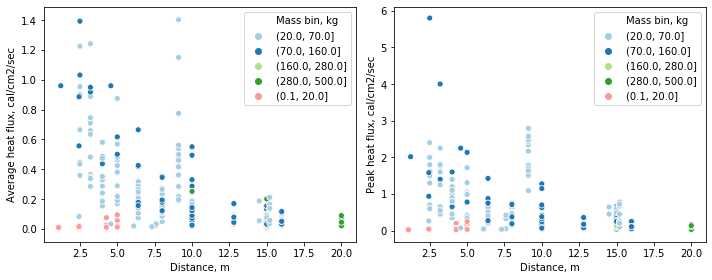

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sea.scatterplot(df['Distance, m'],df['Average heat flux, cal/cm2/sec'],hue=df['Mass bin, kg'],ax=ax[0])
sea.scatterplot(df['Distance, m'],df['Peak heat flux, cal/cm2/sec'],hue=df['Mass bin, kg'],ax=ax[1])
plt.tight_layout()
plt.show()

In [24]:
dfsub = df.drop(['Reference ID','Test #','Propellant type','Drum diameter, cm',
                 'Reference','Notes','Unique ID','Distance, m','Safe Heat Flux, cal/cm2/sec'],axis=1) #remove columns with strings

The below pair plot shows each variable plotted against the others with the color scheme based on the mass bins above.

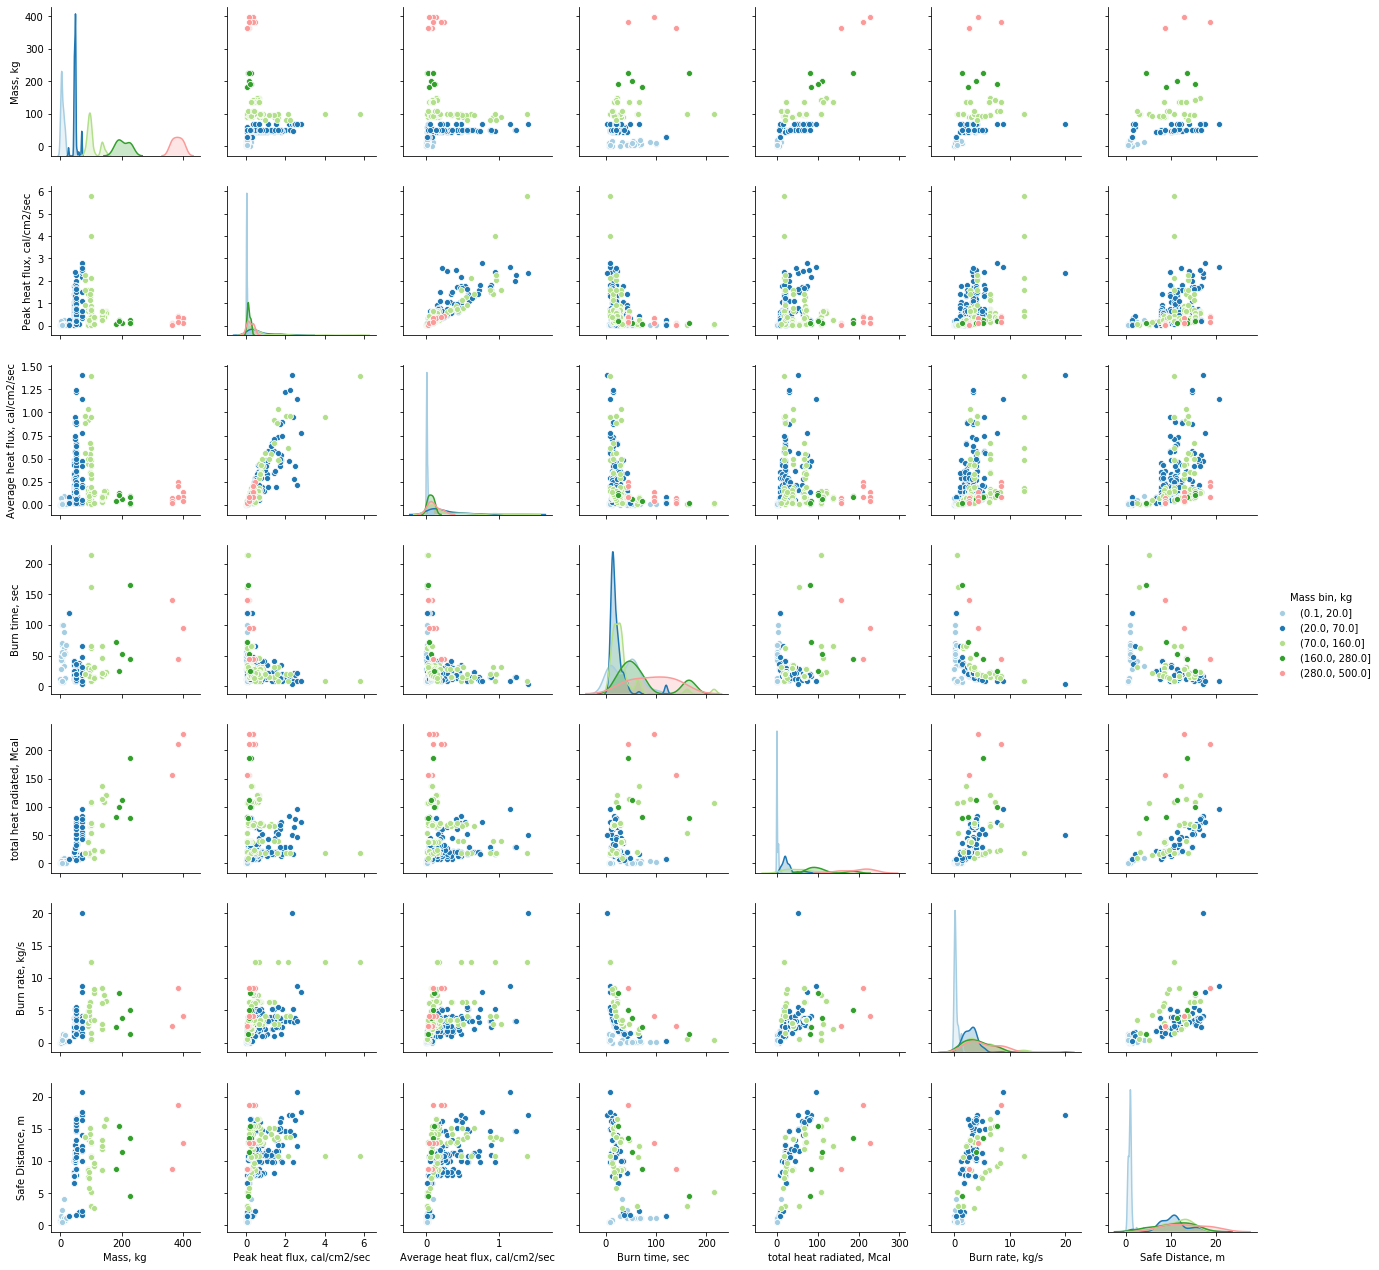

In [25]:
sea.pairplot(dfsub, hue="Mass bin, kg")
plt.show()

From the above pair plot there are a number of apparrent correlations: <br>
  - peak heat flux is proportional to average heat flux
  - total heat radiated is inversly proportional to average and peak heat flux
  - burn time is also inversly proportional to average and peak heat flux
  - safe distance appears to correlate to the burn rate

## Add modeling results from COMSOL with Radiation in Participating Media

In [26]:
dfm = pd.read_csv('jupyterfiles\parametricstudy.csv')
dft = pd.concat([df,dfm])

In [27]:
dfm

,"Drum diameter, cm","Safe Distance, m","Burn rate, kg/s",Unique ID,Propellant type
0,0.360000,7.493090,0.5,M1,Model
1,0.360000,8.804850,1.0,M2,Model
2,0.360000,9.279851,2.0,M3,Model
3,0.360000,8.384938,5.0,M4,Model
4,0.360000,6.826140,10.0,M5,Model
5,0.600000,12.632831,0.5,M6,Model
6,0.600000,13.695287,1.0,M7,Model
7,0.600000,16.083813,2.0,M8,Model
8,0.600000,16.415350,5.0,M9,Model
9,0.600000,15.173929,10.0,M10,Model


## Plot of the Burn rate versus the Safe distance

The safe distance correlates to the burn rate.  This relationship can be used to predict the safe distance given a burn rate.

In [28]:
factor = np.percentile(dft['Safe Distance, m']/(dft['Burn rate, kg/s']**(1/3)),92)
factor

9.919972513022028

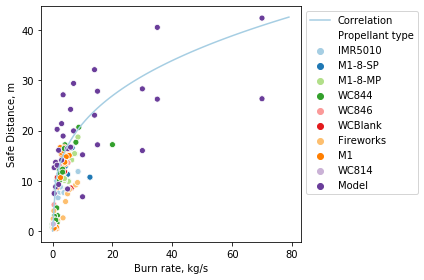

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sea.scatterplot(dft['Burn rate, kg/s'],dft['Safe Distance, m'], hue=dft['Propellant type'])
x = np.arange(0,80); y=factor*x**(1/3)
plt.plot(x,y,label='Correlation')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Model for the safe distance as a function of burn rate:
The above regression correlation relating the safe distance to the burn rate is given below where D is the safe distance in meters and B is the burn rate in kg/sec.
\begin{align}
D(m) & = 9.92\cdot B(kg/s)^{1/3}
\end{align}